# Gaussian Naive Bayesian alogorithm
**52장의 카드에서 하트를 연달아 2번 골라낼 확률은 ?**
- $P(A, B) = P(B/A)*P(A) = (13-1)/(52-1) x (13/52)$ : 동시확률은 교집합
- $P(B, A) = P(A/B)*P(B)$
- $P(B/A) = P(A, B) / P(A) = P(A/B)*P(B) / P(A)$, $B = 가설, A = 관측자료$
- 사후확률 = 우도 * 사전확률 / (모든 A가 발생할 확률, marginal probability)

<img src='https://images.unsplash.com/photo-1541278107931-e006523892df?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxzZWFyY2h8MTN8fGNhcmQlMjBnYW1lfGVufDB8fDB8fA%3D%3D&auto=format&fit=crop&w=800&q=60'>


<img src='https://mblogthumb-phinf.pstatic.net/20160622_22/alwaysneoi_1466583096349iiYdV_PNG/%C1%B6%B0%C7%BA%CE_%C8%AE%B7%FC.png?type=w2'>

**사후확률을 직접 구하기는 힘들지만 데이터의 분포에서 사전확률과 우도를 구하면 사후확률을 쉽게 구할 수 있다.**
<img src = 'https://miro.medium.com/max/1313/1*lx--GFnyowNVBLOXrkPuaQ.png'>
- https://scikit-learn.org/stable/modules/naive_bayes.html

<img src='https://miro.medium.com/max/1313/1*_DyCqF1TdNdlqI4v-MHEfQ.gif'>

<img src='https://miro.medium.com/max/797/1*atTatWle6TzK7l7q1EDz9Q.jpeg'>

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams['font.family']='Malgun Gothic' # 한글폰트

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, plot_roc_curve, plot_confusion_matrix, classification_report

from sklearn.pipeline import Pipeline, make_pipeline

# 모델저장
from joblib import dump, load

# <font color='red'> 퀴즈
### 전체 인구중 10%가 코로나 확진자이며, 요즘같은 이른 봄에 목에 통증이 있는 인구 비율은 20%로, 
### 코로나에 걸린 모든 사람 중 70%가 목에 통증을 호소하고 있다.
### 만약 회식 중에 동료가 목에 통증을 호소한다면 이 동료가 코로나에 걸릴 확률은?

**1. Probability density function이 우도(likelihood)**

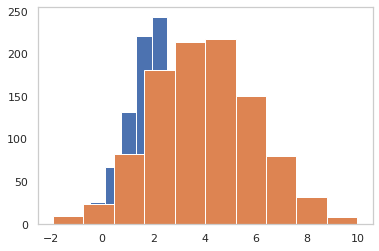

In [2]:
sns.set_style("whitegrid", {'axes.grid' : False})
mu_A, sigma_A = 2, 1
ax = plt.hist(np.random.normal(mu_A, sigma_A, size=(1000)))
mu_B, sigma_B = 4, 2
ax = plt.hist(np.random.normal(mu_B, sigma_B, size=(1000)))

In [3]:
import scipy
scipy.stats.norm(mu_A, sigma_A).pdf(2) # '2'를 관측하였을 경우 A분포의 우도
print('\n')
scipy.stats.norm(mu_B, sigma_B).pdf(2) # '2'를 관측하였을 경우 B분포의 우도

0.3989422804014327

0.12098536225957168

**2. Wiki 예제 MAP (Maximum A posterior)**

https://en.wikipedia.org/wiki/Naive_Bayes_classifier

**3. Gaussian Naive Bayes**

<img src= 'https://wikimedia.org/api/rest_v1/media/math/render/svg/1eaed580cf7c29f044a9e517f1cd4a7dd69c4b1f'>

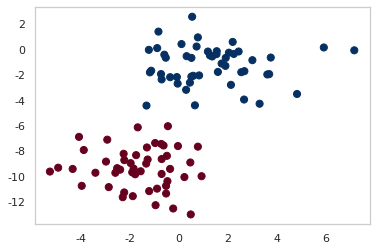

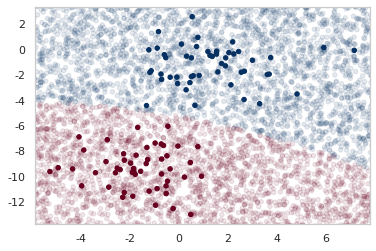

In [4]:
from sklearn.datasets import make_blobs
plt.rcParams['axes.unicode_minus'] = False
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');plt.show()

from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y);

rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(5000, 2)
ynew= model.predict(Xnew)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.1)
plt.axis(lim);

- 의사결정경계선이 곡선으로 나타나고 예측 확률은 '0', '1'에 편중하여 생성

Text(0.5, 1.0, 'Naive Bayes Model')

[(-15.0, 5.0), (-8.0, 8.0)]

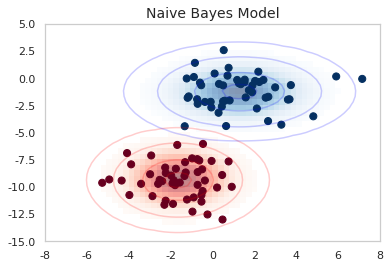

In [5]:
fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
ax.set_title('Naive Bayes Model', size=14)

xlim = (-8, 8)
ylim = (-15, 5)

xg = np.linspace(xlim[0], xlim[1], 60)
yg = np.linspace(ylim[0], ylim[1], 40)
xx, yy = np.meshgrid(xg, yg)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

for label, color in enumerate(['red', 'blue']):
    mask = (y == label)
    mu, std = X[mask].mean(0), X[mask].std(0)
    P = np.exp(-0.5 * (Xgrid - mu) ** 2 / std ** 2).prod(1)
    Pm = np.ma.masked_array(P, P < 0.03)
    ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5,
                  cmap=color.title() + 's')
    ax.contour(xx, yy, P.reshape(xx.shape),
               levels=[0.01, 0.1, 0.5, 0.9],
               colors=color, alpha=0.2)
    
ax.set(xlim=xlim, ylim=ylim)

(array([2086.,   66.,   37.,   35.,   42.,   32.,   44.,   43.,   66.,
        2549.]),
 array([3.0043337e-16, 1.0000000e-01, 2.0000000e-01, 3.0000000e-01,
        4.0000000e-01, 5.0000000e-01, 6.0000000e-01, 7.0000000e-01,
        8.0000000e-01, 9.0000000e-01, 1.0000000e+00]),
 <a list of 10 Patch objects>)

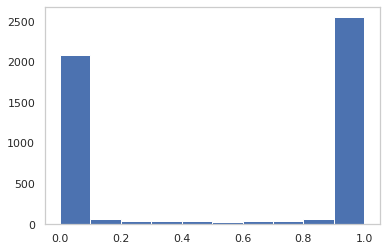

In [6]:
yprob = model.predict_proba(Xnew)
plt.hist(yprob[:, 1])

베이지안 이론에서 확률이란 관측된 사실(데이터)에 따라 변화되는 신념(credibility)

**4. Text mining scikit-learn API**

In [7]:
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
corpus
df = pd.DataFrame(corpus, columns=['content'])
df

['This is the first document.',
 'This document is the second document.',
 'And this is the third one.',
 'Is this the first document?']

,content
0,This is the first document.
1,This document is the second document.
2,And this is the third one.
3,Is this the first document?


In [8]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus) # X = vectorizer.fit_transform(df['content'])
print(vectorizer.get_feature_names())
print(X.toarray())

data = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())
data

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]


,and,document,first,is,one,second,the,third,this
0,0,1,1,1,0,0,1,0,1
1,0,2,0,1,0,1,1,0,1
2,1,0,0,1,1,0,1,1,1
3,0,1,1,1,0,0,1,0,1


TF–IDF
- CountVectorizer 방식의 단점은 너무 자주 나오는 단어에 가중치가 높아져 sub-optimal in some classification algorithms.
- 이러한 점을 보완하기 위해 *term frequency-inverse document frequency* (*TF–IDF*) 

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()
X = vec.fit_transform(corpus)
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,and,document,first,is,one,second,the,third,this
0,0.000000,0.469791,0.580286,0.384085,0.000000,0.000000,0.384085,0.000000,0.384085
1,0.000000,0.687624,0.000000,0.281089,0.000000,0.538648,0.281089,0.000000,0.281089
2,0.511849,0.000000,0.000000,0.267104,0.511849,0.000000,0.267104,0.511849,0.267104
3,0.000000,0.469791,0.580286,0.384085,0.000000,0.000000,0.384085,0.000000,0.384085


- 총 3개의 문서가 리스트형식으로 있다고 가정

In [10]:
sample_kor = ['아버지가 가방에 들어가신다.', '어머니는 시장에 가신다', '붙여쓰면모르지']
vec = CountVectorizer()
X = vec.fit_transform(sample_kor)
X.toarray()
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

array([[1, 0, 1, 0, 0, 1, 0],
       [0, 1, 0, 0, 1, 0, 1],
       [0, 0, 0, 1, 0, 0, 0]])

,가방에,가신다,들어가신다,붙여쓰면모르지,시장에,아버지가,어머니는
0,1,0,1,0,0,1,0
1,0,1,0,0,1,0,1
2,0,0,0,1,0,0,0


**5. Multinomial Naive Bayes**
- 단어의 출현빈도가 특성변수와 관련
- 20 Newsgroups corpus를 사용하여 3개의 그룹으로 분류하는 방법

In [11]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups()
data.keys()
df = pd.DataFrame(data['data'], columns= ['content'])
df['target'] = pd.Series(data.target)
convert = dict(zip(np.arange(len(data.target_names)), data.target_names, ))
df['categories'] = df['target'].map(convert)
df.head()
df.shape

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

,content,target,categories
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


(11314, 3)

In [12]:
subset='train'

In [13]:
from sklearn.model_selection import train_test_split
X, y = fetch_20newsgroups(return_X_y=True)
from sklearn.model_selection import train_test_split
train_data, test_data, train_target, test_target = train_test_split(X, y, stratify=y)

- TF-IDF vectorizer와 multinomial naive Bayes classifier를 를 pipeline으로 구성
- 파이프라인을 데이터에 적용하여 예측하면
- test data의 레이블을 예측하고 실제 자료의 레이블과 confusion matrix를 확인하면

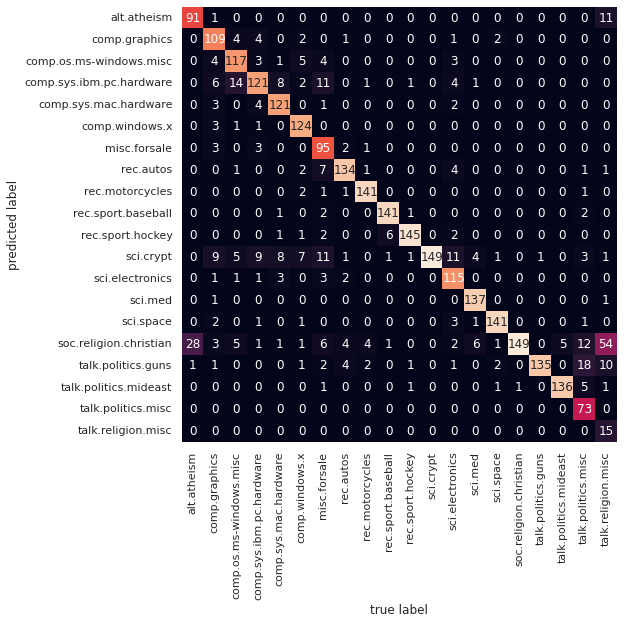

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB 
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

model.fit(train_data, train_target) 
labels = model.predict(test_data)

from sklearn.metrics import confusion_matrix 
mat = confusion_matrix(test_target, labels)
sns.set(rc = {'figure.figsize':(20,8)})
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=data.target_names, yticklabels=data.target_names) 
plt.xlabel('true label') 
plt.ylabel('predicted label');

<font color='red'> 각 단어의 빈도로 예측이 거의 완벽
- 새로운 값(text)를 예측해보자

In [15]:
y_pred = model.predict(['I am a religious robot cop.'])
print(y_pred)
data.target_names
print('\n')
data.target_names[y_pred[0]]

[15]


['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

'soc.religion.christian'

In [16]:
model.predict(['The Russian rocket agency is expected to',
               'Worship like a pop at the Shrine of Your Lies'])

array([14, 15])

In [17]:
data.target_names[14]
data.target_names[15]

'sci.space'

'soc.religion.christian'

**6. 데이터의 특성에 따라 예측을 잘하는 알고리즘이 있음**

<Figure size 576x432 with 0 Axes>

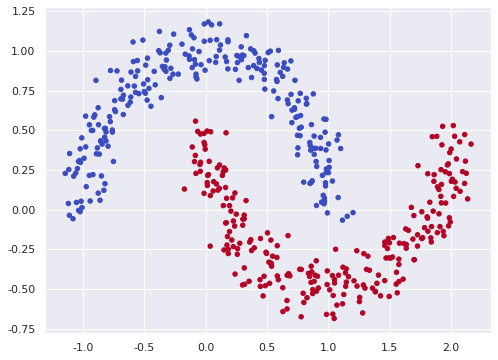

In [18]:
from sklearn.datasets import make_moons, make_circles, make_classification
X, y = make_moons(n_samples=500, noise=0.1)
plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='coolwarm')

Text(0.5, 1.0, 'KNeighborsClassifier()')

Text(0.5, 1.0, 'GaussianNB()')

Text(0.5, 1.0, 'SGDClassifier()')

Text(0.5, 1.0, 'LogisticRegression()')

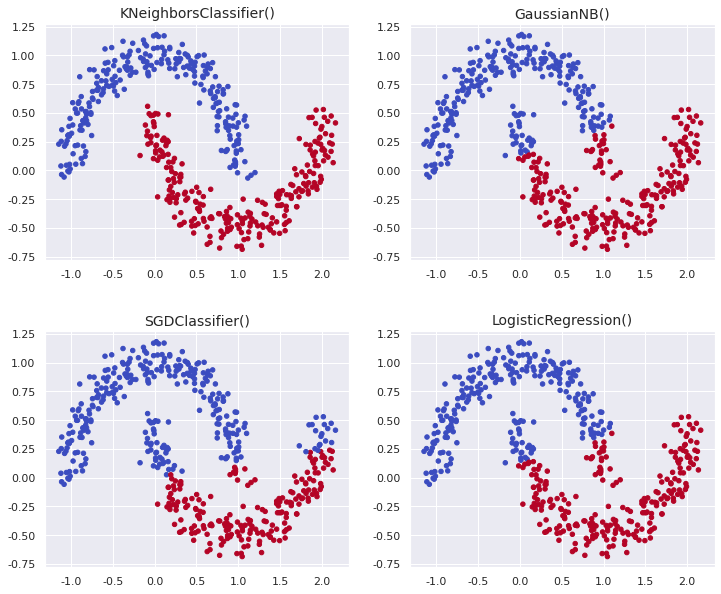

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression

fig, axs = plt.subplots(2,2, figsize=(12, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.2)
axs = axs.ravel()
classifiers = [KNeighborsClassifier(), GaussianNB(), 
               SGDClassifier(), LogisticRegression()]
for i, classifier in enumerate(classifiers) :
    axs[i].set_title(str(classifier), fontsize='14')
    y_pred = classifier.fit(X, y).predict(X) 
    axs[i].scatter(X[:, 0], X[:, 1], c=y_pred, s=20, cmap='coolwarm')

# END